# BREATHING WAVE
## DEEP LEARNING - LSTM
### 04 March 2023
#### V3 = with cross-validation technique included

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

# Enable XLA
tf.config.optimizer.set_jit(True)

df = pd.read_csv("breathing_waveform_data.csv").iloc[:, :-1] # get rid of last column ("notes")

X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

In [3]:
# Check if the data do not have any NULL 
print("X have a null? \t{}".format(X.isnull().values.any()))
print("Y have a null? \t{}".format(Y.isnull().values.any()))

X have a null? 	False
Y have a null? 	False


In [4]:
X

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
0,0.483309,0.459790,0.431024,0.376565,0.295734,0.193290,0.066060,-0.083445,-0.247221,-0.409374,...,0.332737,0.391514,0.452677,0.521407,0.595845,0.661691,0.702932,0.708613,0.682564,0.637765
1,-2.044518,-1.935588,-1.808629,-1.667919,-1.513497,-1.348760,-1.171044,-0.972509,-0.759554,-0.547793,...,0.325687,0.138731,-0.053860,-0.241691,-0.417603,-0.582320,-0.738485,-0.889731,-1.037066,-1.174654
2,-1.213535,-1.269056,-1.323306,-1.375251,-1.430062,-1.485479,-1.529200,-1.557172,-1.574662,-1.575457,...,0.902226,0.947940,0.996154,1.035743,1.049543,1.024204,0.954716,0.844505,0.702445,0.541555
3,-0.914806,-0.887726,-0.856065,-0.823527,-0.794551,-0.768074,-0.740895,-0.713364,-0.685445,-0.652020,...,-0.407344,-0.478218,-0.571465,-0.684115,-0.817078,-0.966231,-1.122537,-1.264759,-1.376908,-1.461059
4,-1.547469,-1.458818,-1.362120,-1.264829,-1.164948,-1.060064,-0.954496,-0.849448,-0.742812,-0.636614,...,0.322969,0.227050,0.130983,0.041438,-0.038034,-0.106152,-0.163048,-0.210926,-0.253102,-0.290270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26395,-0.152463,-0.164723,-0.165409,-0.152623,-0.118115,-0.066218,-0.010253,0.041637,0.092217,0.140510,...,-0.345803,-0.336787,-0.306774,-0.280607,-0.269843,-0.260062,-0.229981,-0.167654,-0.082300,0.004372
26396,-0.164723,-0.165409,-0.152623,-0.118115,-0.066218,-0.010253,0.041637,0.092217,0.140510,0.188025,...,-0.336787,-0.306774,-0.280607,-0.269843,-0.260062,-0.229981,-0.167654,-0.082300,0.004372,0.089958
26397,-0.165409,-0.152623,-0.118115,-0.066218,-0.010253,0.041637,0.092217,0.140510,0.188025,0.240939,...,-0.306774,-0.280607,-0.269843,-0.260062,-0.229981,-0.167654,-0.082300,0.004372,0.089958,0.179209
26398,-0.152623,-0.118115,-0.066218,-0.010253,0.041637,0.092217,0.140510,0.188025,0.240939,0.294399,...,-0.280607,-0.269843,-0.260062,-0.229981,-0.167654,-0.082300,0.004372,0.089958,0.179209,0.264014


In [5]:
Y.value_counts()

normal        19734
quick          2667
hold           2133
deep           1066
deep_quick      800
Name: labels, dtype: int64

### Program Starting
# PART 1 : Data Preprocessing

## Hot Encoded The Label Data 

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encode class values as integers [0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,2]
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

# convert integers to dummy variables (i.e. one hot encoded)
hot_y = np_utils.to_categorical(encoded_Y)

## Scale The Training Data (STD)

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

## Reshaping The Training Data to 3-Dimensional Numpy Array
### STRUCTURE : (batch_size, timestep, feature)

In [8]:
timestep = 5
X = np.reshape(X, (X.shape[0], int(85/timestep), timestep))
# (26400, 17, 5)
# 5 indicator will be used per sequence/timestep per sample/row

# PART 2 : Building The RNN

In [8]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

## Creating Layer of RNN

In [9]:
# Configuration for Model Structure
from keras.optimizers import Adam
_optimizer = Adam()
_loss = "categorical_crossentropy"
_metric = ["accuracy"]

In [10]:
classifier = Sequential()

# first layer
classifier.add(LSTM(units=60, return_sequences=True, input_shape=(17, 5)))
classifier.add(Dropout(0.2))    # Ignore 20% of the neuron (ex. 50 * 20% = 10 neuoron will be ignored) 

# second layer
classifier.add(LSTM(units=60, return_sequences=True))
classifier.add(Dropout(0.2))

# third layer
# classifier.add(LSTM(units=20, return_sequences=True))
# classifier.add(Dropout(0.2))

# fourth layer
classifier.add(LSTM(units=60))
classifier.add(Dropout(0.2))

# last layer
classifier.add(Dense(units=5, activation='softmax'))

# Compile
classifier.compile(optimizer=_optimizer, loss=_loss, metrics=_metric)

# Plot Summary of Model
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 17, 60)            15840     
                                                                 
 dropout (Dropout)           (None, 17, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 17, 60)            29040     
                                                                 
 dropout_1 (Dropout)         (None, 17, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense (Dense)               (None, 5)                 3

# PART 3 : Training Time

## Train the Model - Cross Validation (Stratified K-Fold)

In [11]:
from tensorflow.keras.initializers import GlorotUniform
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Setting for training arguments (epoch, batch_size)
ep = 15       # epoch
bt = 32        # batch_size

# Create an instance of StratifiedKFold with the desired number of folds
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)

# encode class values as integers [0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,2]
encoder = LabelEncoder()

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
for fold, (train_idx, val_idx) in enumerate(skf.split(X, Y)):
    print('Fold:', fold+1)
    X_train, Y_train = X[train_idx], hot_y[train_idx]
    X_val, Y_val = X[val_idx], hot_y[val_idx]
    

    # Train the model on the training set
    classifier.fit(X_train, Y_train, epochs=ep, batch_size=bt, validation_data=(X_val, Y_val))
    # Record the evaluation metric for this fold - training data
    history['loss'].append(classifier.history.history['loss'][-1] * 100)
    history['accuracy'].append(classifier.history.history['accuracy'][-1] * 100)
    
    # Evaluate the model on the validation set
    loss, accuracy = classifier.evaluate(X_val, Y_val, verbose=0)
    # print('Validation Loss\t\t: {:.2f}%'.format(loss*100))
    # print('Validation Accuracy\t: {:.2f}%'.format(accuracy*100))

    # Record the evaluation metric for this fold - validation data
    history['val_loss'].append(loss*100)
    history['val_accuracy'].append(accuracy*100)
    
    # saving the model
    filename = "{}\\{}\\{}-f{}.h5".format(os.getcwd(), "MODELS\\[3-layer] - 3L1\\CV\\StratifiedKFold", fold+1, n_splits)
    classifier.save(filename)
    
    # clear all the weight - set all weight to random number
    classifier.set_weights([GlorotUniform(seed=21)(w.shape) for w in classifier.weights])

# Calculate the mean and standard deviation of the evaluation metric across all folds
mean_loss = np.mean(history['val_loss'], axis=0)
std_loss = np.std(history['val_loss'], axis=0)
mean_accuracy = np.mean(history['val_accuracy'], axis=0)
std_accuracy = np.std(history['val_accuracy'], axis=0)

Fold: 1
Epoch 1/15
743/743 [==============================] - 14s 14ms/step - loss: 0.7182 - accuracy: 0.7670 - val_loss: 0.6316 - val_accuracy: 0.7731
Epoch 2/15
743/743 [==============================] - 10s 13ms/step - loss: 0.5726 - accuracy: 0.7849 - val_loss: 0.4692 - val_accuracy: 0.8220
Epoch 3/15
743/743 [==============================] - 10s 13ms/step - loss: 0.4298 - accuracy: 0.8370 - val_loss: 0.3490 - val_accuracy: 0.8777
Epoch 4/15
743/743 [==============================] - 10s 13ms/step - loss: 0.3235 - accuracy: 0.8847 - val_loss: 0.2574 - val_accuracy: 0.9121
Epoch 5/15
743/743 [==============================] - 10s 13ms/step - loss: 0.2485 - accuracy: 0.9162 - val_loss: 0.1914 - val_accuracy: 0.9413
Epoch 6/15
743/743 [==============================] - 10s 13ms/step - loss: 0.1952 - accuracy: 0.9366 - val_loss: 0.1532 - val_accuracy: 0.9511
Epoch 7/15
743/743 [==============================] - 10s 13ms/step - loss: 0.1537 - accuracy: 0.9494 - val_loss: 0.1078 - val_a

743/743 [==============================] - 10s 13ms/step - loss: 0.1950 - accuracy: 0.9361 - val_loss: 0.1426 - val_accuracy: 0.9568
Epoch 9/15
743/743 [==============================] - 11s 15ms/step - loss: 0.1540 - accuracy: 0.9503 - val_loss: 0.1069 - val_accuracy: 0.9655
Epoch 10/15
743/743 [==============================] - 10s 13ms/step - loss: 0.1324 - accuracy: 0.9581 - val_loss: 0.1126 - val_accuracy: 0.9644
Epoch 11/15
743/743 [==============================] - 10s 13ms/step - loss: 0.1155 - accuracy: 0.9637 - val_loss: 0.1020 - val_accuracy: 0.9674
Epoch 12/15
743/743 [==============================] - 10s 13ms/step - loss: 0.0968 - accuracy: 0.9695 - val_loss: 0.0761 - val_accuracy: 0.9750
Epoch 13/15
743/743 [==============================] - 10s 13ms/step - loss: 0.0906 - accuracy: 0.9710 - val_loss: 0.0813 - val_accuracy: 0.9720
Epoch 14/15
743/743 [==============================] - 10s 13ms/step - loss: 0.0841 - accuracy: 0.9751 - val_loss: 0.0657 - val_accuracy: 0.980

In [12]:
history

{'loss': [6.596960872411728,
  7.834737002849579,
  7.499384880065918,
  7.442329823970795,
  7.403828203678131,
  7.570268213748932,
  8.628030121326447,
  7.327746599912643,
  7.730916142463684,
  8.394622057676315],
 'val_loss': [5.978681519627571,
  5.635573714971542,
  7.653045654296875,
  7.240819931030273,
  5.328895151615143,
  5.9324003756046295,
  6.3884928822517395,
  5.897023901343346,
  7.794691622257233,
  8.385276794433594],
 'accuracy': [98.1607735157013,
  97.64730930328369,
  97.8787899017334,
  97.76515364646912,
  97.79882431030273,
  97.7314829826355,
  97.4158227443695,
  97.87458181381226,
  97.63888716697693,
  97.44949340820312],
 'val_accuracy': [98.21969866752625,
  98.40909242630005,
  97.91666865348816,
  97.91666865348816,
  98.44697117805481,
  98.44697117805481,
  98.03030490875244,
  97.99242615699768,
  97.61363863945007,
  97.42424488067627]}

In [13]:
print('[Lowest] Validation Loss\t\t\t: {:.2f}%'.format(np.min(history['val_loss'])))
print('[Highest] Validation Loss\t\t\t: {:.2f}%'.format(np.max(history['val_loss'])))
print('Mean Validation Loss\t\t\t\t: {:.2f}%'.format(mean_loss))
print('Standard Deviation of Validation Loss\t\t: {:.2f}%'.format(std_loss))
print()
print('[Lowest] Validation Accuracy\t\t\t: {:.2f}%'.format(np.min(history['val_accuracy'])))
print('[Highest] Validation Accuracy\t\t\t: {:.2f}%'.format(np.max(history['val_accuracy'])))
print('Mean Validation Accuracy\t\t\t: {:.2f}%'.format(mean_accuracy))
print('Standard Deviation of Validation Accuracy\t: {:.2f}%'.format(std_accuracy))
print("\n-----------------------------------")
print("RESULT OF PREDICTIONS - K-FOLD")
print("-----------------------------------")
from prettytable import PrettyTable
  
columns = ["Fold", "loss", "accuracy", "val_loss", "val_accuracy"]
  
myTable = PrettyTable()
  
# Add Columns
myTable.add_column(columns[0], np.arange(1, n_splits+1))
myTable.add_column(columns[1], [str(round(i, 2)) for i in history['loss']])
myTable.add_column(columns[2], [str(round(i, 2)) for i in history['accuracy']])
myTable.add_column(columns[3], [str(round(i, 2)) for i in history['val_loss']])
myTable.add_column(columns[4], [str(round(i, 2)) for i in history['val_accuracy']])

# sort the table by salary in descending order
myTable.sortby = "val_accuracy"
myTable.reversesort = True
  
print(myTable)

[Lowest] Validation Loss			: 5.33%
[Highest] Validation Loss			: 8.39%
Mean Validation Loss				: 6.62%
Standard Deviation of Validation Loss		: 1.00%

[Lowest] Validation Accuracy			: 97.42%
[Highest] Validation Accuracy			: 98.45%
Mean Validation Accuracy			: 98.04%
Standard Deviation of Validation Accuracy	: 0.33%

-----------------------------------
RESULT OF PREDICTIONS - K-FOLD
-----------------------------------
+------+------+----------+----------+--------------+
| Fold | loss | accuracy | val_loss | val_accuracy |
+------+------+----------+----------+--------------+
|  6   | 7.57 |  97.73   |   5.93   |    98.45     |
|  5   | 7.4  |   97.8   |   5.33   |    98.45     |
|  2   | 7.83 |  97.65   |   5.64   |    98.41     |
|  1   | 6.6  |  98.16   |   5.98   |    98.22     |
|  7   | 8.63 |  97.42   |   6.39   |    98.03     |
|  8   | 7.33 |  97.87   |   5.9    |    97.99     |
|  4   | 7.44 |  97.77   |   7.24   |    97.92     |
|  3   | 7.5  |  97.88   |   7.65   |    97.92  

# PART 4 : Testing the Loaded Model

In [1]:
from tensorflow.keras.models import load_model
filename = "{}\\{}\\{}.h5".format(os.getcwd(), "MODELS\\[3-layer] - 3L1\\CV\\KFold", "6-f10")

# load model
loaded_model = load_model(filename)

NameError: name 'os' is not defined

## Evaluate the Model

In [21]:
score = loaded_model.evaluate(X, hot_y)
print("Accuracy \t: {:.2f}".format(score[1]*100))
print("Loss \t\t: {:.2f}".format(score[0]*100))

825/825 [==============================] - 6s 7ms/step - loss: 0.0589 - accuracy: 0.9826
Accuracy 	: 98.26
Loss 		: 5.89


In [23]:
pred = loaded_model.predict(X)

825/825 [==============================] - 6s 7ms/step


In [26]:
y_true = np.argmax(hot_y, axis=1)
y_pred = np.argmax(pred, axis=1)

## Plot Confusion Matrix

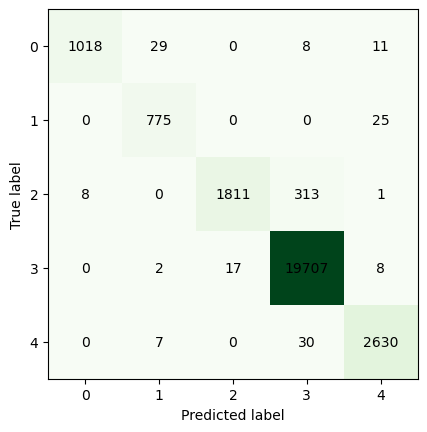

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Define the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Greens)

# Add labels to the plot
tick_marks = np.arange(len(conf_matrix))
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add values to the plot
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center')

# Show the plot
plt.show()